In [1]:
import pandas as pd;
import numpy as np;
import datetime as dt;

# for visualization 
%pylab
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 

# for machine learning algorithm 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
fileNameStr='C:/Users/10138/Desktop/data_analysis/python_data_analysis/电商数据实战/Online Retail.xlsx'
ORdata = pd.read_excel(fileNameStr)
ORdata.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 一、 数据清洗

## 1.1 查看数据基本信息

In [3]:
ORdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
ORdata.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## 1.2 缺失值处理

In [5]:
ORdata.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

将description和customerID存在缺失值，直接做删除处理

In [6]:
ORdata = ORdata.dropna()
ORdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


## 1.3 重复值删除

In [7]:
ORdataUni = ORdata.drop_duplicates()
ORdata.shape[0]-ORdataUni.shape[0]

5225

一共删除了5225条重复值

## 1.4 异常值处理

In [8]:
ORdataUni.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


quantity指的是购买的数量，不可能存在负数；UnitPrice是单价，不可能存在负值。将异常值直接删除。

In [9]:
saleOR = ORdataUni.loc[(ORdataUni['Quantity']>0) & (ORdataUni['UnitPrice']>0)]

# 二、RFM模型寻找价值用户

使用RFM模型对用户进行分类，根据用户分类可以进行精细化运营。

RFM主要的三个指标：
R(Recency) 最近一次消费时间:用户最近一次购买到现在的时间间隔；Recency越短越有价值
F(Frequency) 消费频率:用户在特定时间段内的购买次数；次数越多越有价值
M(Monetary) 消费金额:用户在特定时期的消费总金额；金额越大越有价值

## 2.1 R,F,M 指标计算

In [10]:
# 统计中的购买日期是范围是2011-01-18到2011-12-02
# R值定义为 最近一次购买日期 距离 2011-12-03 的时间间隔

saleOR['CustomerID']=saleOR['CustomerID'].apply(lambda x:int(x))
Nowdate = saleOR.InvoiceDate.max()+dt.timedelta(days=1)
saleOR = saleOR.drop_duplicates(subset=['InvoiceNo'])

saleOR['TotalSum'] = saleOR['UnitPrice']*saleOR['Quantity']
saleOR.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,54.08
21,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047,United Kingdom,25.50
25,536369,21756,BATH BUILDING BLOCK WORD,3,2010-12-01 08:35:00,5.95,13047,United Kingdom,17.85


建立用户数据表，每一行代表一个用户的信息

In [11]:
CusDate = saleOR.groupby(['CustomerID']).agg({'InvoiceDate':lambda x:(Nowdate-x.max()).days,
                                    'InvoiceNo':'count',
                                    'TotalSum':'sum'}).reset_index()

CusDate.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalSum':'MonetaryValue'}
           ,inplace= True)
CusDate['Recency'] = CusDate['Recency'].map(lambda x:round(x/30,2)) 
CusDate.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12346,10.87,1,77183.60
1,12347,0.07,7,163.16
2,12348,2.50,4,331.36
3,12349,0.63,1,15.00
4,12350,10.33,1,25.20


## 2.2 查看R,F,M 指标分布

呈现R,F,M值的分布情况，以便后续对RFM进行高低维度划分提供依据

### R分布

In [12]:
CusDate['Recency'].describe()

count    4338.000000
mean        3.084514
std         3.333842
min         0.030000
25%         0.600000
50%         1.700000
75%         4.730000
max        12.470000
Name: Recency, dtype: float64

In [13]:
# 切片情况呈现
# 每隔一个月作为一个区间
bins_R = np.arange(13)
pd.cut(CusDate['Recency'],bins_R).value_counts()

(0, 1]      1648
(1, 2]       748
(2, 3]       493
(3, 4]       232
(5, 6]       181
(4, 5]       176
(8, 9]       163
(7, 8]       156
(6, 7]       155
(9, 10]      118
(10, 11]     117
(11, 12]      59
Name: Recency, dtype: int64

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


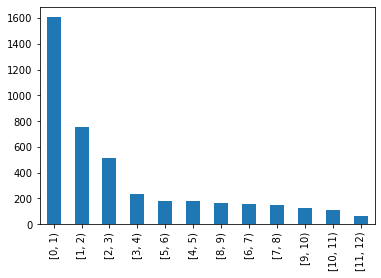

In [14]:
import matplotlib.pyplot as plt
%pylab
%matplotlib inline
pd.cut(CusDate['Recency'],bins_R,right=False).value_counts().plot.bar()


### F分布

In [15]:
CusDate['Frequency'].describe()

count    4338.000000
mean        4.272015
std         7.697998
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       209.000000
Name: Frequency, dtype: float64

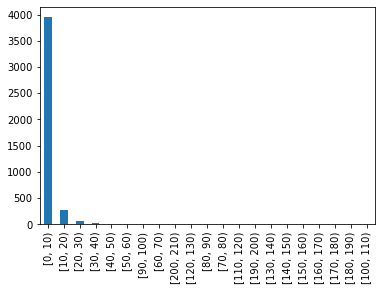

In [16]:
m = np.arange(211)
bins_F= m[::10]
pd.cut(CusDate['Frequency'], bins_F,right=False).value_counts().plot.bar()

### M分布

In [17]:
CusDate['MonetaryValue'].describe()

count      4338.000000
mean        296.914539
std        3128.698664
min           0.390000
25%          17.700000
50%          47.050000
75%         130.102500
max      168471.250000
Name: MonetaryValue, dtype: float64

In [18]:
bins_M = [0,10,50,100,1000,10000,100000,200000]
pd.cut(CusDate['MonetaryValue'],bins_M,right=False).value_counts()

[10, 50)            1736
[100, 1000)         1172
[50, 100)            784
[0, 10)              496
[1000, 10000)        137
[10000, 100000)       12
[100000, 200000)       1
Name: MonetaryValue, dtype: int64

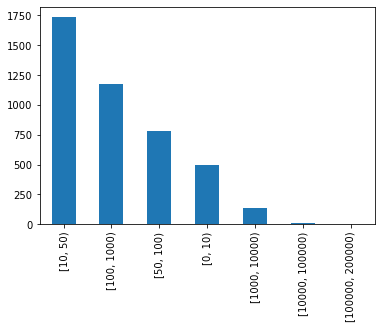

In [19]:
pd.cut(CusDate['MonetaryValue'],bins_M,right=False).value_counts().plot.bar()

## 2.3 RFM模型搭建(方法一)

分别计算三个指标的中位数，每个指标与中位数进行比较，划分高低
2*2*2一共会得到8组分类

为每一个用户的R,F,M值进行高低维度的划分；高用‘H’表示，低用‘L’表示。高与低是针对用户值的高低而言的。
R值若小于中位数，则为高，否则为低
F值若大于中位数，则为高，否则为低
M值若大于中位数，则为高，否则为低

In [20]:
R_median = CusDate['Recency'].median()
CusDate['R_label'] = pd.cut(CusDate['Recency'],bins=[0,R_median,CusDate['Recency'].max()+1],right=False
                                ,labels=['H','L'])
CusDate.groupby(['R_label'])['CustomerID'].count() 

R_label
H    2158
L    2180
Name: CustomerID, dtype: int64

In [21]:
F_median = CusDate['Frequency'].median()
CusDate['F_label'] = pd.cut(CusDate['Frequency'],bins=[0,F_median,CusDate['Frequency'].max()+1],
                            right=False,labels=['L','H'])
CusDate.groupby(['F_label'])['CustomerID'].count() 

F_label
L    1493
H    2845
Name: CustomerID, dtype: int64

In [22]:
M_median = CusDate['MonetaryValue'].median()
CusDate['M_label'] = pd.cut(CusDate['MonetaryValue'],bins=[0,M_median,CusDate['MonetaryValue'].max()+1],
                            right=False,labels=['L','H'])
CusDate.groupby(['M_label'])['CustomerID'].count() 

M_label
L    2169
H    2169
Name: CustomerID, dtype: int64

In [23]:
CusDate.head()

,CustomerID,Recency,Frequency,MonetaryValue,R_label,F_label,M_label
0,12346,10.87,1,77183.60,L,L,H
1,12347,0.07,7,163.16,H,H,H
2,12348,2.50,4,331.36,L,H,H
3,12349,0.63,1,15.00,H,L,L
4,12350,10.33,1,25.20,L,L,L


In [24]:
def add_rfm(x):
    return str(x['R_label'])+str(x['F_label'])+str(x['M_label'])
CusDate['RFM_label'] = CusDate.apply(add_rfm, axis =1)
CusDate.head()

,CustomerID,Recency,Frequency,MonetaryValue,R_label,F_label,M_label,RFM_label
0,12346,10.87,1,77183.60,L,L,H,LLH
1,12347,0.07,7,163.16,H,H,H,HHH
2,12348,2.50,4,331.36,L,H,H,LHH
3,12349,0.63,1,15.00,H,L,L,HLL
4,12350,10.33,1,25.20,L,L,L,LLL


### 用户分类结果

In [25]:
CusDate.groupby(['RFM_label'])['CustomerID'].count()

RFM_label
HHH    1321
HHL     481
HLH      42
HLL     314
LHH     630
LHL     413
LLH     176
LLL     961
Name: CustomerID, dtype: int64

## 2.4 RFM模型搭建 (方法二)

(1) 将三个指标分别等分 进行打分
(2) 分别计算三个指标 打分 的平均值，每个指标与平均值进行比较，划分高低
(3) 2*2*2=8,一共8类数据

### R,F,M指标打分

将R,F，M值分别划分为1-4等级，对应1-4分，分数越高，用户价值越高

In [26]:
r_labels=list(range(4,0,-1))
f_labels=list(range(1,5))
m_labels=list(range(1,5,1))
print(list(f_labels))
CusDate['Frequency'].describe()

[1, 2, 3, 4]


count    4338.000000
mean        4.272015
std         7.697998
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       209.000000
Name: Frequency, dtype: float64

In [27]:
CusDate['r_score'] = pd.qcut(CusDate['Recency'],q=4,duplicates='drop',labels=r_labels)
CusDate['f_score'] = pd.qcut(CusDate['Frequency'],q=5,duplicates='drop',labels=f_labels)
CusDate['m_score'] = pd.qcut(CusDate['MonetaryValue'],q=4,duplicates='drop',labels=m_labels)
CusDate['Frequency'].describe()
CusDate['RFM_score'] = CusDate['r_score'].astype('float')+CusDate['f_score'].astype('float')+CusDate['m_score'].astype('float')

In [28]:
mean_R_score = CusDate['r_score'].astype('float').mean()
mean_F_score = CusDate['f_score'].astype('float').mean()
mean_M_score = CusDate['m_score'].astype('float').mean()
print(mean_R_score,mean_F_score,mean_M_score)

2.5138312586445366 1.9709543568464731 2.4972337482710927


### R,F,M 高低划分

根据指标分数与总体得分的平均值进行比较，划分高低

In [29]:
CusDate['r_score_label'] = pd.cut(CusDate['r_score'],bins=[0,mean_R_score,5],
                            right=True,labels=['L','H'])  # 左开右毕（0，2.5] (2.5,4])
CusDate['f_score_label'] = pd.cut(CusDate['f_score'],bins=[0,mean_R_score,5],
                            right=True,labels=['L','H'])  # 左开右毕（0，2.5] (2.5,4])
CusDate['m_score_label'] = pd.cut(CusDate['m_score'],bins=[0,mean_M_score,5],
                            right=True,labels=['L','H'])  # 左开右毕（0，2.5] (2.5,4])

In [30]:
def score_label_segment(CusDate):
    return str(CusDate['r_score_label']) +str(CusDate['f_score_label'])+str(CusDate['m_score_label'])
CusDate['RFM_score_label'] = CusDate.apply(score_label_segment,axis=1)
CusDate.head()

,CustomerID,Recency,Frequency,MonetaryValue,R_label,F_label,M_label,RFM_label,r_score,f_score,m_score,RFM_score,r_score_label,f_score_label,m_score_label,RFM_score_label
0,12346,10.87,1,77183.60,L,L,H,LLH,1,1,4,6.0,L,L,H,LLH
1,12347,0.07,7,163.16,H,H,H,HHH,4,4,4,12.0,H,H,H,HHH
2,12348,2.50,4,331.36,L,H,H,LHH,2,3,4,9.0,L,H,H,LHH
3,12349,0.63,1,15.00,H,L,L,HLL,3,1,1,5.0,H,L,L,HLL
4,12350,10.33,1,25.20,L,L,L,LLL,1,1,2,4.0,L,L,L,LLL


### 两种求解RFM模型的方法比较

#### 方法一：

In [31]:
CusDate.groupby(['RFM_label'])['CustomerID'].count()

RFM_label
HHH    1321
HHL     481
HLH      42
HLL     314
LHH     630
LHL     413
LLH     176
LLL     961
Name: CustomerID, dtype: int64

#### 方法二：

In [32]:
CusDate.groupby(['RFM_score_label'])['CustomerID'].count()

RFM_score_label
HHH    1075
HHL     102
HLH     303
HLL     708
LHH     286
LHL      39
LLH     505
LLL    1320
Name: CustomerID, dtype: int64

In [33]:
CusDate.groupby(['RFM_score_label'])['RFM_score'].mean()

RFM_score_label
HHH    10.861395
HHL     8.539216
HLH     8.161716
HLL     6.026836
LHH     8.604895
LHL     6.461538
LLH     6.138614
LLL     3.930303
Name: RFM_score, dtype: float64

上述两种方法想比较可知：分类之后每一类别的用户数量是有较大差异的。方法二由于选择平均值划分高低，而数据存在左偏现象。所以类别间用户数差异明显。LHL和HHL组内分别只有6人和10人，不能为用户分析提供价值。而方法一得到的用户分群结果相对更合理。
因此，在数量量严重倾斜时，选择中位数作为评判的标准，可行性是更高的。

对于模型好坏的评价标准，更应该结合业务进行评判。

# 三、K-means聚类寻找价值用户

In [34]:
RFM = CusDate[['CustomerID','Recency','Frequency','MonetaryValue']]
RFM.describe()

,CustomerID,Recency,Frequency,MonetaryValue
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,3.084514,4.272015,296.914539
std,1721.808492,3.333842,7.697998,3128.698664
min,12346.000000,0.030000,1.000000,0.390000
25%,13813.250000,0.600000,1.000000,17.700000
50%,15299.500000,1.700000,2.000000,47.050000
75%,16778.750000,4.730000,5.000000,130.102500
max,18287.000000,12.470000,209.000000,168471.250000


## 3.1 选择特征值和样本数据
### 特征值使用R, F, M

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


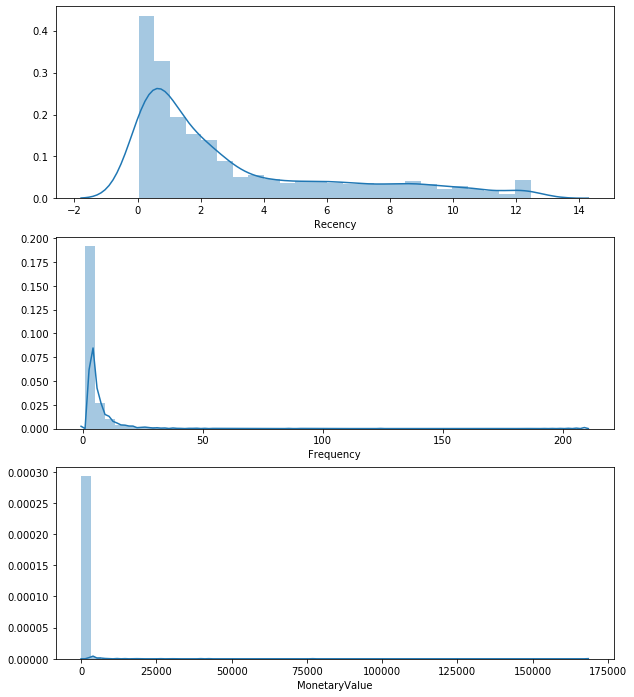

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
%pylab
%matplotlib inline
f,ax = plt.subplots(3,1,figsize=(10, 12))
plt.subplot(3,1,1); sns.distplot(RFM['Recency'],label='Recency')
plt.subplot(3,1,2); sns.distplot(RFM['Frequency'],label='Frequency')
plt.subplot(3,1,3); sns.distplot(RFM['MonetaryValue'],label='MonetaryValue')

K-means算法对数据的要求：
(1)变量值是对称分布的
(2)变量进行归一化处理，平均值和方差均相同

由R,F,M三个变量的分布图可知，变量值分布不满足对称性，可以使用对数变换解决

## 3.2 数据预处理

### (1) 对数变换

In [36]:
# 将等于0的值替换成1，否则log变换后会出现无穷大的情况，无法使用distplot
RFM.Recency[RFM['Recency']==0]=0.01
RFM.Recency[RFM['Frequency']==0]=0.01
RFM.Recency[RFM['MonetaryValue']==0]=0.01
RFM['Recency'].describe()
RFM_log = RFM[['Recency','Frequency','MonetaryValue']].apply(np.log,axis=1).round(3)
# RFM_log['Recency'].describe()
# RFM['Recency'].describe()

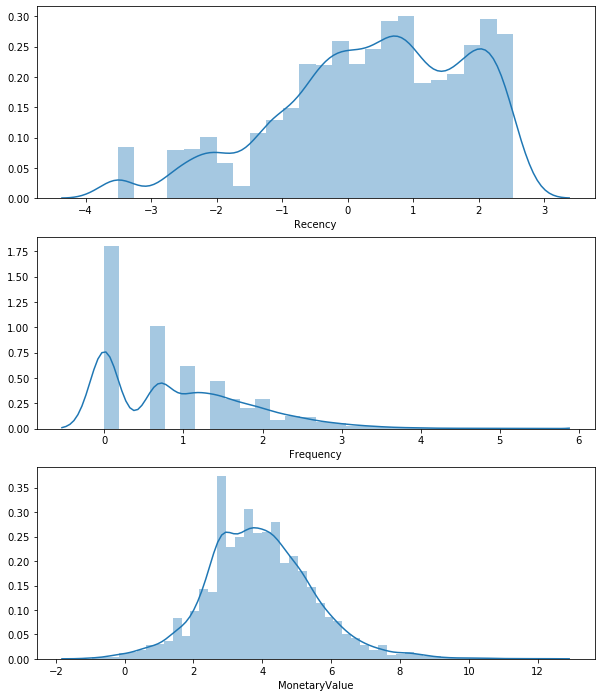

In [37]:
f,ax = plt.subplots(3,1,figsize=(10, 12))
plt.subplot(3,1,1); sns.distplot(RFM_log['Recency'],label='Recency')
plt.subplot(3,1,2); sns.distplot(RFM_log['Frequency'],label='Frequency')
plt.subplot(3,1,3); sns.distplot(RFM_log['MonetaryValue'],label='MonetaryValue')

### (2) 标准化处理

 fit() 预处理的数据，计算矩阵列均值和列标准差       
 transform（data） 得到标准化的矩阵  ,用此方法，必须使用fit先进行预处理计算均值和标准差            
 然后用fit计算的均值和标准差，进行标准化处理  {x_i - u}/标准差        
 fit_transform(data) 相当于是fit和transform的组合


In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(RFM_log)
RFM_normalization = scaler.transform(RFM_log)

## 3.3 选择聚类数目

###  通常有两种方法，一是肘部法则(Elbow Criterion method)，选择代价函数下降的显著转折点; 二是业务经验
### 这里使用肘部法则进行K值选择，并且使用Calinski-Harabasz Index进行评估

In [39]:
from sklearn.cluster import KMeans
# k值的选择，1~8
ks = range(1,9)
inertias=[]
for k in  ks:
    kc = KMeans(n_clusters=k, init='k-means++', random_state = 1)
    kc.fit(RFM_normalization)
    inertias.append(kc.inertia_) # 样本距离其聚类中心的距离平方和

    print('k=',k,' 迭代次数',kc.n_iter_)

k= 1  迭代次数 2
k= 2  迭代次数 8
k= 3  迭代次数 19
k= 4  迭代次数 61
k= 5  迭代次数 21
k= 6  迭代次数 30
k= 7  迭代次数 96
k= 8  迭代次数 24


绘制每个K值对应的inertia_

Text(0.5, 1.0, 'Elbow Criterion method to find best k')

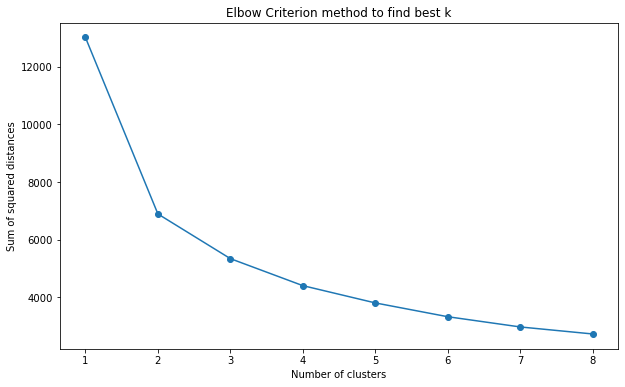

In [40]:
f,ax = subplots(figsize=(10,6))
plt.plot(ks, inertias,'-o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Criterion method to find best k')

根据肘部法则定理，可以看到当k=2，3时，代价函数下降会有一个显著转折点。计算K=2和K=3时Calinski-Harabasz Index对应的值

In [41]:
from sklearn import metrics
kk = range(2,9)
for k in kk:
    y_pred = KMeans(n_clusters=k, random_state=1).fit_predict(RFM_normalization) #k必须大于1
    calinski = metrics.calinski_harabaz_score(RFM_normalization, y_pred)
    print('k:',k,'   calinski=',calinski)

k: 2    calinski= 3850.5792408991447
k: 3    calinski= 3111.8628177429787
k: 4    calinski= 2821.93334700249
k: 5    calinski= 2619.693743897193
k: 6    calinski= 2521.071800973828
k: 7    calinski= 2437.0066461847027
k: 8    calinski= 2329.96118662267


k=2时，calinski_harabaz_scores是最大的，其次是k=3。结合业务而言，如果将用户分成两类，精确度不够高，因此接下来选择k=3进行接下来的验证

## 3.4 模型计算

In [42]:
kc = KMeans(n_clusters=3, random_state=1)
kc.fit(RFM_normalization)
#  每个样本对应的类簇标签，顺序与样本原始顺序一致
cluster_label = kc.labels_
RFM['K-means_label'] = cluster_label
RFM.head()

,CustomerID,Recency,Frequency,MonetaryValue,K-means_label
0,12346,10.87,1,77183.60,1
1,12347,0.07,7,163.16,2
2,12348,2.50,4,331.36,1
3,12349,0.63,1,15.00,0
4,12350,10.33,1,25.20,0


In [43]:
RFM.head()

,CustomerID,Recency,Frequency,MonetaryValue,K-means_label
0,12346,10.87,1,77183.60,1
1,12347,0.07,7,163.16,2
2,12348,2.50,4,331.36,1
3,12349,0.63,1,15.00,0
4,12350,10.33,1,25.20,0


## 3.5 组内特征

In [44]:
RFM.groupby(['K-means_label']).agg({'Recency':'mean','Frequency':'mean','MonetaryValue':['mean','count']})

Recency  Frequency MonetaryValue      
                   mean       mean          mean count
K-means_label                                         
0              5.323421   1.238681     24.145847  1789
1              2.014286   3.456446    171.681266  1722
2              0.469674  12.532044   1147.742696   827

对于RFM模型而言，R越小越好，而F和M则越大越好。因此，类别0的群体是最有价值的用户群体。

类别2群体的其他特征信息

除了每位顾客的R,F,M信息之外，Country也是一个重要的特征描述

In [45]:
# 将原始数据的country信息合并到RFM表格中
saleOR_country = saleOR.drop_duplicates(subset=['CustomerID','Country'])
Customer_feature = pd.merge(left = RFM, right =saleOR_country[['CustomerID','Country']],
                            left_on='CustomerID', right_on='CustomerID',how='left')

In [46]:
Customer_feature.pivot_table(Customer_feature,index = ['K-means_label','Country'],
                             aggfunc='count')['CustomerID']
label02_feature=Customer_feature.loc[Customer_feature['K-means_label']==2,:].groupby(['Country']).count()
label02_feature.sort_values('CustomerID',ascending=False)
#United Kingdom 1625人

label01_feature=Customer_feature.loc[Customer_feature['K-means_label']==1,:].groupby(['Country']).count()
label01_feature.sort_values('CustomerID',ascending=False)
#United Kingdom 1568人

label00_feature=Customer_feature.loc[Customer_feature['K-means_label']==0,:].groupby(['Country']).count()
label00_feature.sort_values('CustomerID',ascending=False);
#United Kingdom 727人

In [49]:
1789/4338

0.4124020285846012

对标签为0，1，2的三类用户分别查看所属国家信息，发现来自United Kingdom的比例分别是16.8%, 36.2%, 37.4%。
来自英国的人数总占比为90.4%，国家这一特征对于三类用户而言并没有明显的差异性

### 不同组内的用户特征总结：

类别00的用户群体：占总人群的41.2%。Recency,Frequency, MonetrryValue的平均值分别为5.3，1.2，24.1
类别01的用户群体：占总人群的39.7%。Recency,Frequency, MonetrryValue的平均值分别为2.0，3.5，171.7
类别02的用户群体：占总人群的19.0%。Recency,Frequency, MonetrryValue的平均值分别为0.5，12.5，1147.8

### 由此可见，类别02群体是价值最高的用户群体。可以对类别02的用户群体采取重点跟进维系措施。